# Entrenamiento y Evaluación de Modelos

Este notebook se encarga de:
1.  Cargar los datos procesados mediante `ft_engineering.py`.
2.  Entrenar modelos base (Regresión Logística, Árbol de Decisión, Random Forest).
3.  Evaluar y comparar su desempeño con métricas robustas.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import sys
import os

# Añadir directorio actual al path para importar módulos locales
sys.path.append(os.path.abspath(''))

# Importar función de ingeniería de características
from ft_engineering import feature_engineering, cargar_datos

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.1)


## 1. Carga y Preprocesamiento de Datos

In [2]:
# Cargar datos originales
try:
    # Ruta asumiendo ejecución desde mlops_pipeline/src o similar, ajustamos para buscar desde root si falla
    ruta_db = '../../Base_de_datos.xlsx' 
    if not os.path.exists(ruta_db):
        ruta_db = 'Base_de_datos.xlsx' # Intento local directo
        
    print(f"Cargando dataset desde: {ruta_db}")
    df_raw = cargar_datos(ruta_db)
    
    # Aplicar Pipeline de Ingeniería de Características
    print("Aplicando Feature Engineering...")
    X_train, X_test, y_train, y_test, preprocessor = feature_engineering(df_raw, target_col='Pago_atiempo')
    
    # Ajustar índices para evitar problemas en concatenación futura si fuera necesario
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    
except Exception as e:
    print(f"Error crítico en carga de datos: {e}")


Cargando dataset desde: ../../Base_de_datos.xlsx


Aplicando Feature Engineering...
Variables Numéricas (19): ['tipo_credito', 'capital_prestado', 'plazo_meses', 'edad_cliente', 'salario_cliente', 'total_otros_prestamos', 'cuota_pactada', 'puntaje', 'puntaje_datacredito', 'cant_creditosvigentes', 'huella_consulta', 'saldo_mora', 'saldo_total', 'saldo_principal', 'saldo_mora_codeudor', 'creditos_sectorFinanciero', 'creditos_sectorCooperativo', 'creditos_sectorReal', 'promedio_ingresos_datacredito']
Variables Categóricas (2): ['tipo_laboral', 'tendencia_ingresos']
Ingeniería de características completada.
Shape Train: (8610, 62)
Shape Test: (2153, 62)


## 2. Funciones de Entrenamiento y Evaluación

In [3]:
def build_model(model, X_train, y_train):
    """
    Entrena el modelo proporcionado con los datos de entrenamiento.
    """
    print(f"Entrenando {model.__class__.__name__}...")
    model.fit(X_train, y_train)
    return model

def summarize_classification(y_true, y_pred, y_prob=None, title="Modelo"):
    """
    Imprime reporte de clasificación y retorna diccionario de métricas.
    """
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    roc_auc = "N/A"
    if y_prob is not None:
        try:
            roc_auc = roc_auc_score(y_true, y_prob)
        except:
            pass
            
    print(f"--- {title} ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    if roc_auc != "N/A":
        print(f"ROC AUC:   {roc_auc:.4f}")
    print("\n")
    
    return {
        'Model': title,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    }

def plot_confusion_matrix(y_true, y_pred, title):
    """
    Grafica matriz de confusión.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusión - {title}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()


## 3. Entrenamiento de Modelos Base

Probaremos tres algoritmos estándar:
1. **Regresión Logística**: Baseline lineal simple.
2. **Árbol de Decisión**: Modelo no lineal interpretable.
3. **Random Forest**: Modelo de ensamble robusto.

Entrenando LogisticRegression...
--- Logistic Regression ---
Accuracy:  0.9986
Precision: 0.9990
Recall:    0.9995
F1-Score:  0.9993
ROC AUC:   1.0000




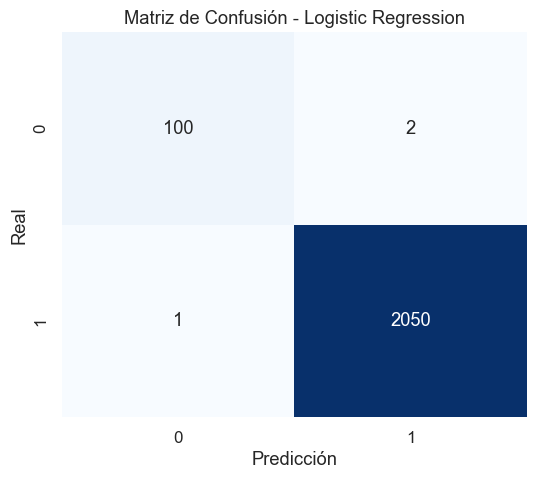

Entrenando DecisionTreeClassifier...
--- Decision Tree ---
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC AUC:   1.0000




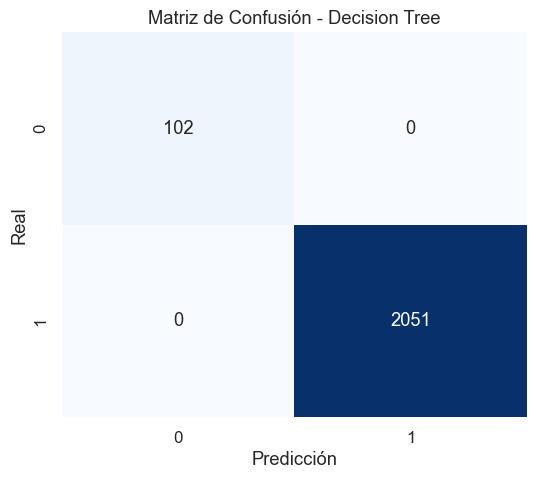

Entrenando RandomForestClassifier...


--- Random Forest ---
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000
ROC AUC:   1.0000




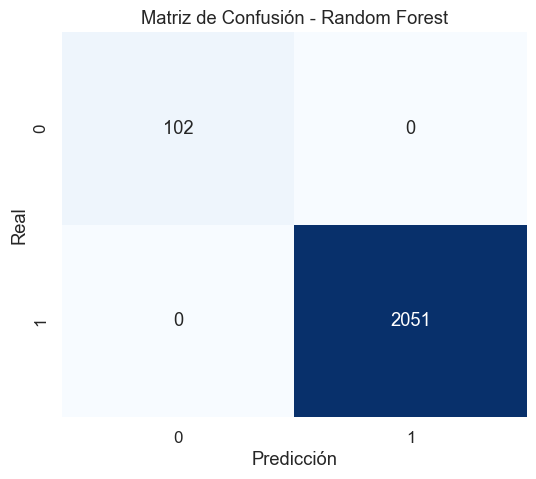

In [4]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
}

results_list = []
trained_models = {}

for name, model in models.items():
    # Entrenar
    clf = build_model(model, X_train, y_train)
    trained_models[name] = clf
    
    # Predecir
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None
    
    # Evaluar
    metrics = summarize_classification(y_test, y_pred, y_prob, title=name)
    results_list.append(metrics)
    
    # Matriz de Confusión
    plot_confusion_matrix(y_test, y_pred, name)


## 4. Comparación de Modelos

Visualización comparativa de las métricas clave para seleccionar el mejor candidato.

                 Model  Accuracy  Precision    Recall  F1-Score   ROC AUC
0  Logistic Regression  0.998607   0.999025  0.999512  0.999269  0.999971
1        Decision Tree  1.000000   1.000000  1.000000  1.000000  1.000000
2        Random Forest  1.000000   1.000000  1.000000  1.000000  1.000000


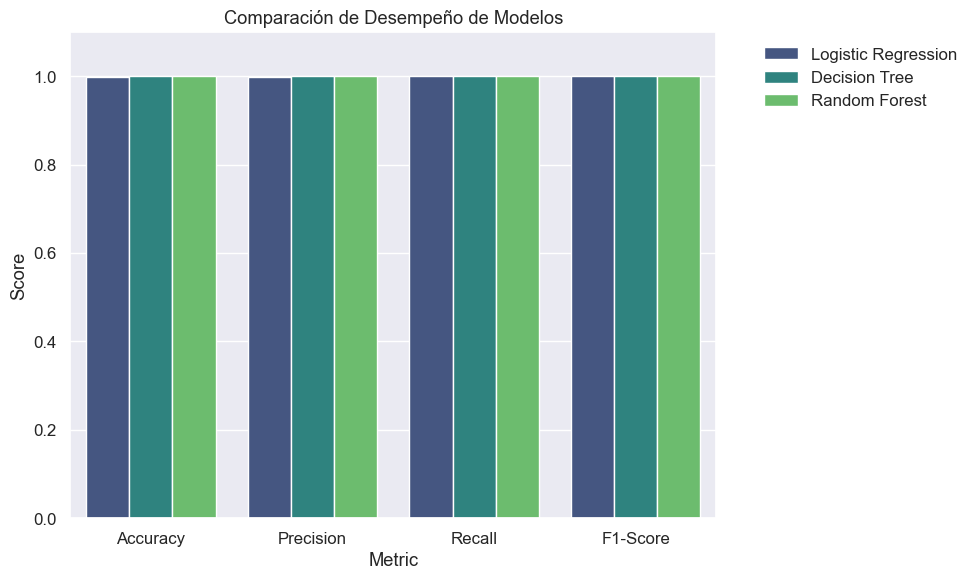

In [5]:
results_df = pd.DataFrame(results_list)
print(results_df)

# Graficar Comparación
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
df_melted = results_df.melt(id_vars='Model', value_vars=metrics_to_plot, var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model', palette='viridis')
plt.title('Comparación de Desempeño de Modelos')
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
